A primer for working with the **_Sp_**atial **_Int_**eraction modeling (SpInt) module in the python spatial analysis library (PySAL)
===================================================================================================================


## Introduction

Spatial interaction modeling involves the analysis of flows from an origin to a destination, either over physical space (i.e., migration) or through abstract space (i.e., telecommunication). Despite being a fundamental technique to many geogaphic disciplines, there is relatively little software available to carry out spatial interaction modeling and the analysis of flow data. Therefore, the purpose of this primer is to provide an overview of the recently develped spatial interaction modeling (SpInt) module of the python spatial analysis library (PySAL). First, the current framework of the module will be highlighted. Next, the main functionality of the module will be illustrated using migration flows with a dataset previously used for spatial interaction modeling tutorials in the R programming environment. Finally, some future additions are discussed. 


## The SpInt Framework

### Modeling framework

The core purpose of the SpInt module is to provide the functionality to calibrate spatial interaction models. Since the "family" of spatial interaction models put forth by Wilson (Wilson, 1971) are perhaps the most popular, they were chosen as the starting point of the module. Consider the basic gravity model (Fotheringham & O'Kelly, 1989), 

$$T_{ij} = k\frac{V_{i}^\mu W_{j}^\alpha}{d_{ij}^\beta} \quad(1)$$


where 

- $T_{ij}$ = an $n \times m$ matrix of flows between $n$ origins (subscripted by $i$) to $m$ destinations (subscripted by $j$) 


- $V$ = an $n \times p$ and vector of $p$ origin attributes describing the emissiveness of $i$ 


- $W$ = an $m \times p$ vector of $p$ destination attributes describing the attractiveness of $j$ 


- $d$ = an $n \times m$ matrix of the costs to overcome the physical separation between  $i$ and $j$ (usually distance or time) 


- $k$ = a scaling factor to be estimated to ensure the total observed and predicted flows are consistent 


- $\mu$ = a $p \times 1$ vector of parameters representing the effect of $p$ origin attributes on flows 


- $\alpha$ = a $p \times 1$ vector of parameters representing the effect of $p$ destination attributes on flows 


- $\beta$ = an exponential parameter representing the effect of movement costs on flows. 


When data for $T$, $V$,  $W$, and $d$ are available we can estimate the model parameters (also called calibration), which summarize the effect that each model component contributes towards explaining the system of known flows ($T$). In contrast, known parameters can be used to predict unknown flows when there are deviations in model components ($V$, $W$, and $d$) or the set of locations in the system are altered.

Using an entropy-maximizing framework, Wilson derives a more informative and flexible "family" of four spatial interaction models (Wilson, 1971). This framework seeks to assign flows between a set of origins and destinations by finding the most probable configuration of flows out of all possible configurations, without making any additional assumptions. By using a common optimization problem and including information about the total inflows and outflows at each location (also called constraints), the following "family" of models can be obtained,

$$
\begin{align}
&Unconstrained \  \\
&Tij = V_{i}^\mu W_{j}^\alpha  f(d_{ij}) \quad & (2) \\
\\
&Production-constrained \\
&T_{ij} = A_{i}O_{i}W_{j}^\alpha f(d_{ij}) \quad & (3) \\
&A_{i} = \sum_{j} W_{j}^\alpha f(d_{ij}) \quad & (3a) \\
\\
&Attraction-constrained \\
&T_{ij} = B_{j}D_{j}V_{i}^\mu f(d_{ij}) \quad & (4) \\
&B_{j} = \sum_{i} V_{i}^\mu f(d_{ij}) \quad & (4a) \\
\\
&Doubly-constrained \\
&T_{ij} = A_{i}B_{j}O_{i}D_{j}f(d_{ij}) \quad & (5) \\
&A_{i} = \sum_{j} W_{j}^\alpha B_{j} D_{j} f(d_{ij}) \quad & (5a) \\
&B_{j} = \sum_{i} V_{i}^\mu A_{i} O_{i} f(d_{ij}) \quad & (5b)
\end{align}
$$


where 

- $O_{i}$ = an $n \times 1$ vector of the total number of flows emanating from origin $i$

- $D_{j}$ = an $m \times 1$ vector of the total number of flows terminating at destination $j$

- $A_{i}$ = an $n \times 1$ vector of the origin balancing factors that ensures the total out-flows are preserved in the predicted flows

- $B_{j}$ = an $m \times 1$ vector of the destination balancing factors that ensures the total in-flows are preserved in the predicted flows

- $f(d_{ij})$ = a function of cost or distance, referred to as the distance-decay function. Most commonly this an exponential or power function given by,

$$
\begin{align}
&Power\\
&f(d_{ij}) = d_{ij}^\beta \quad & (6) \\
\\
&Exponential \\
&f(d_{ij}) = exp(\beta*d_{ij}) \quad & (7) \\
\end{align}
$$

where $\beta$ is expected to take a negative value. Different distance-decay functions assume different responses to the increasing costs associated with moving to more distant locations. Of note is that the unconstrained model with a power function distance-decay is equivalent to the basic gravity model in equation (2), except that the scaling factor, $k$, is not included. In fact, there is no scaling factor in any of the members of the family of maximum entropy models because there is a total trip constrained implied in their derivation and subsequently their calibration (Fotheringham & O'Kelly , 1989). Another aside is that in the doubly-constrained maximum entoropy model, the values for $A_{i}$ and $B_{j}$ are dependent upon each other and may need to be computed iteratively depending on calibration technqiue. It is also usually assumed that all locations are both origins and destinations (i.e., $n=m$) for doubly-constrained models.

Each member of the family of models provides a different system strucutre , which can be chosen depedning on the available data or the specific research question at hand. The so-called unconstrained model does not conserve the total inflows or outflows during parameter estimation. The production-constrained and attraction-constrained models conserve either the number of total inflows or outflows, respectively, and are therefore useful for building models that allocate flows either to a set of origins or to a set of destinations. Finally, the doubly-constrained model conserves both the inflows and the outflows at each location during model calibration. The quantity of explanatory information provided by each model is given by the number of parameters it provides. As such, the unconstrained model provides the most information, followed by the two singly-constrained models, with the doubly-constrained model providing the least information. Conversely, the model's predictive power increases with higher quantities of built-in information (i.e. total in or out-flows) so that the doubly-constrained model usually provides the most accurate predictions, followed by the two singly-constrained models, and the unconstrained model supplying the weakest predictions (Fotheringham & O'Kelly, 1989). 

### Calibration framework

Spatial interaction models are often calibrated via linear programming, nonlinear optimization, or increasingly more often through linear regression. Given the flexibility and extendability of a regression framework it was chosen as the primary model calibration technqiue within the SpInt module. By taking the natural logarithm of both sides of a spatial interaction model, say the basic gravity model, is is possible to obtain the so-called log-linear or log-normal spatial interaction model,


$$
\begin{align}
& Power-function \\
&\ln{T_{ij}} = k + \mu \ln{V_{i}} + \alpha \ln{W_{j}} - \beta \ln{d_{ij}} + \epsilon \quad &(8a) \\
\\
& Exponential-function \\
&\ln{T_{ij}} = k + \mu \ln{V_{i}} + \alpha \ln{W_{j}} - \beta {d_{ij}} + \epsilon \quad &(8b) \\
\end{align}
$$


where $\epsilon$ is a a normally distributed error term with a mean of 0. The only difference between equations (8a) and (8b) is the functional distance-decay specification, which results from plugging either equation (6) for a power function or (7) for an exponential function into equation (2) before linearizing it. The only practical difference here is that the distance is logged in equation (8a) whereas in equation (8b) it is not. Constrained spatial interaction models can be achieved by including fixed effects for the origins (production-constrained), fixed effects for the destinations (attraction-constrained) or both (doubly-constrained). However, there are several limitations of the log-normal gravity model, which include,

1. flows are often counts of people or objects and should be modeled as discrete entities; 
2. flows are often not normally distributed;
3. downward biased flow predictions due to producing estimates for the logarithm of flows instead of actual flows
4. zero flows are problematic since the logarithm of zero is undefined.

Therefore, Flowerdew and Aitkin (1982) propose the Poisson log-linear regression specification for the family of spatial interaction models. This specification assumes that the number of flows between $i$ and $j$ is drawn from a Poisson distribution with mean, $\lambda_{ij} = T_{ij}$, where $\lambda_{ij}$ is assumed to be logarithmically linked to the linear combination of variables,

$$\ln{\lambda_{ij}} = k + \mu \ln V_{i} + \alpha \ln W_{j} - \beta \ln d_{ij}) \quad (9a)$$

and exponentiating both sides of the equation yields the unconstrained Poisson log-linear gravity model,

$$T_{ij} = \exp(k + \mu \ln V_{i} + \alpha \ln W_{j} - \beta \ln d_{ij}) \quad (9b) $$

where equations (9a) and (9b) refer to the unconstrained model with a power function distance-decay. As previously mentioned, using fixed effects for the balancing in equations (3-5) factors, the constrained variants of the family of spatial interaction models can be specified as,

$$
\begin{align}
&Production-constrained \\
&T_{ij} = \exp(k + \mu_{i} + \alpha \ln W_{j} - \beta \ln d_{ij}) \quad & (10) \\
\\
&Attraction-constrained \\
&T_{ij} = \exp(k + \mu \ln V_{i} + \alpha_{j} - \beta \ln d_{ij}) \quad & (11) \\
\\
&Doubly-constrained \\
&T_{ij} = \exp(k + \mu_{i} + \alpha_{j} - \beta \ln d_{ij}) \quad & (12) \\
\end{align}
$$

where $\mu_{i}$ are origin fixed effects and $\alpha_{i}$ are destination fixed effects that achieve the same results as including balancing factors. Similar to equation (8b) the exponential function distance-decay can be specified in equation (9b, 10-12) by ommiting the logarithm associated with $d_{ij}$. Using Poisson regression is more representative of flows and satisfies limaitations (1-2) and it also alleviates limiations (3-4) since we no longer need to take the logarithm of $T_{ij}$. Using fixed effects within Poisson regression to calibrate the doubly-constrained model also avoids the need for iterative computation of the balancing factors that exists in other calibration methods (Fotheringham & O'Kelly, 1989).  

Calibration of Poisson regression can be carried out within a generalized linear modeling framework (GLM) using iteratively weighted least sqaures (IWSL), which converges to the maximum likelihood estimates for the parameter estimates (Nelder & Wedderburn, 1972). To maintain computational efficiency with increasingly larger spatial interaction datasets, SpInt is built upon a custom GLM/IWLS routine that leverages sparse data structures for the production-constrained, attraction-constrained, and doubly-constrained models. As the number of locations in these models increases, so the does the number of binary indicator variables needed to construct the fixed effects that enforce the constraints. Therefore, larger spatial interaction datasets become increasingly sparse and the utilization of sparse data structures take advantage of this feature. As a metric, constrained models with $n = m =  3,000$ locations, which implies $n*m = n^2 = 9,000,000$ observed flows when each location is an origin and destination, can be calibrated within minutes on a standard macbook pro notebook.  

### Model fit statistics

In order to evaluate the fit of spatial interaction models, it has been recommended that a variety of statistics be used (Knudesen & Fotheringham, 1986), which is the apporach taken in SpInt. For the log-normal regression specifcation, it is popular to utilize the coefficient of determination ($R^2$), though this statistic is not available within the GLM framework used by SpInt. In replacement of the $R^2$ statistic, the SpInt framework provides a psuedo $R^2$ based on the likelihood function (McFadden, 1974),


$$R^2_{pseudo} = 1 - \frac{\ln \hat{L}(M_{full})}{\ln \hat{L}(M_{Intercept})} \quad(14)$$

where $\hat{L}$ is the likelihood of an estimated model, $M_{full}$ is the model including all explanatory variables of interest, and $M_{Intercept}$ is the model with only an intercept (i.e., no covariates). Like the $R^2$ statistic, the pseudo version is at a maximum at a value of 1 with higher values denoting better model fit. To acocunt for model complexity, there is also an adjusted version of this statistic,

$$R^2_{adj-pseudo} = 1 - \frac{\ln \hat{L}(M_{full}) - K}{\ln \hat{L}(M_{Intercept})} \quad(15)$$

where $K$ is the number of regressors. If model fit does not sufficiently improve, then it is possuble for this measure to decrease as variables are added, signaling that the additional variables do not contribute towards a better model fit. Henceforth, these psuedo $R^2$ statistics are reffered to soley as $R^2$ and adjusted $R^2$.  Another model fit statistic available in the SpInt module that also acocunts for model complexity is the the Akaike information criterion (AIC),

$$ AIC = -2\ln \hat{L}(M_{full}) + 2K  \quad(16)$$

where lower AIC values indicate a better model fit (Akaike, 1974). This statistic is grounded in information theory, whereby the AIC is an asymptotic estimate of the information that is lost by using the full model to represent a given theoretical process.

The psuedo $R^2$ and AIC are designed for model selection, which means they should not be used to compare between different spatial systems. One solution to issue is the standardized root mean sqaure error (SRMSE),

$$ SRMSE = \frac{\frac{\sqrt{\sum_{i}\sum_{j}(T_{ij} - \hat{T}_{ij})^{2}}}{n*m}}{\frac{\sum_{i}\sum_{j}T_{ij}}{n*m}} \quad(17)$$

where the numberator is the root mean square error of the observed flows, $T_{ij}$, and the flows predicted by the model, $\hat{T}_{ij}$, and the denominator is the mean of the observed flows and is responsbile for standardization of the statistic. Here, $n*m$ is the number of origin-destination pairs that constitue system of flows. A SRMSE value of 0 indicates perfect model fit, while higher values indicate decreasing model fit; however, the upper limit of the statistic is not necessarily 1 and will depend on the distribution of the observed values (Knudsen & Fotheringham, 1986). 

One final fit statistic, a modified Sorensen similarity index (SSI), is included within the SpInt module because it has become increasinly popular in some spatial interaction literature that deals with non-parametric models (Lenormand et al., 2012; Massuci et al., 2012; Yan et al., 2013). Using the same symbol definition from the SRMSE, the SSI is defined as,

$$ SSI = \frac{1}{(n*m)} \sum_{i} \sum_{j} \frac{2min(T_{ij}, \hat{T}_{ij})}{T_{ij} + \hat{T}_{ij}} \quad(18)$$

which is bounded between values of 0 and 1 with values closer to 1 indicating a better model fit. 


## An Illustrative example: migration in Austria

### The data

Despite being a small toy dataset, the following example is utilizes for consistency since it was previously used to demonstrate spatial interaction modeling in the R programming language (Dennett, 2012). The data are migration flows between Austrian NUTS level 2 municipalities in 2006. In order to use a regression-based calibration, the data has to be transformed from the matrices and vectors described in equations (1-5) to a table where each row represents a single origin-destination dyad, $(i,j)$ and any variables associated with locations $i$ and $j$. Details on how to do this are outlined further in (LeSage & Pace, 2008), though this has already been done in the example data. Let's have a look! 

Populating the interactive namespace from numpy and matplotlib


,Unnamed: 0,Origin,Destination,Data,Oi,Dj,Dij
0,0,AT11,AT11,0,4016,5146,1.000000e-300
1,1,AT11,AT12,1131,4016,25741,1.030018e+02
2,2,AT11,AT13,1887,4016,26980,8.420467e+01
3,3,AT11,AT21,69,4016,4117,2.208119e+02
4,4,AT11,AT22,738,4016,8634,1.320075e+02


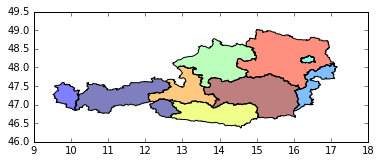

In [19]:
import pandas as pd
import geopandas as gp
%pylab inline
austria_shp = gp.read_file('austria.shp')
austria_shp.plot()
austria = pd.read_csv('austria.csv')
austria.head()

The **Origin** and **Destination** columns refer to the origin, $i$, and destination, $j$, location labels, the **Data** column is the number of flows, the **Oi** and **Dj** columns are the number of total out-flows and total in-flows, respectively, and the **Dij** column is the Euclidian distance between the centroids of $i$ and $j$. In this case we use the total out-flow and total in-flow as variables to describe how emissive an origin is and how attractive a destination is. If we want a more informative and interesting model we can replace these with application specific variables that pertain to different hypotheses. Next, lets format the data into arrays.

In [4]:
austria = austria[austria['Origin'] != austria['Destination']]
flows = austria['Data'].values
Oi = austria['Oi'].values
Dj = austria['Dj'].values
Dij = austria['Dij'].values
Origin = austria['Origin'].values
Destination = austria['Destination'].values

The Oi and Dj vectors need not be $n^2 \times 1$ vectors. In fact, they can be $n^2 \times k$ where $k$ is the number of variables that are either being used to describe origin or desitnation attributes associated with flows. It should also be noted that intra-zonal flows have been excluded (the first line of code above). This is sometimes done becasue intra-zonal flows are large compared to inter-zonal flows and would therefore heavily influence the model or becasue it is not possible to adequately define a distance associated with intra-zonal flows. Some solutions to these issues have been proposed (Kordi et al., 2012; Tsutsumi & Tamesue, 2012), though for simplicity, intra-zonal were removed for this example. Therefore 

### Calibrating the models

Now, lets load the main SpInt functions and calibrate some models. The main SpInt functions are found within the gravity namespace of the SpInt module and the estimated parameters can be accessed via the **params** attribute of a successfully instantiated spatial interaction model.

In [5]:
from pysal.contrib.spint.gravity import Gravity
from pysal.contrib.spint.gravity import Production
from pysal.contrib.spint.gravity import Attraction
from pysal.contrib.spint.gravity import Doubly

Unconstrained (basic gravity) model

In [6]:
gravity = Gravity(flows, Oi, Dj, Dij, 'exp')
print gravity.params

[ -8.01822841e+00   8.69316127e-01   8.91445153e-01  -6.22938370e-03]


Production-constrained model

In [7]:
production = Production(flows, Origin, Dj, Dij, 'exp')
print production.params[-2:]

[ 0.90285448 -0.0072617 ]


Attraction-constrained model

In [8]:
attraction = Attraction(flows, Destination, Oi, Dij, 'exp')
print attraction.params[-2:]

[ 0.90037216 -0.00695034]


Doubly-constrained model

In [9]:
doubly = Doubly(flows, Origin, Destination, Dij, 'exp')
print doubly.params[-1:]

[-0.00791533]


Note that for the constrained models we have limited the params attribute to print only the main model variables (i.e., not fixed effects), though it is still possible to access the fixed effect parameters too.

In [10]:
print production.params

[-1.16851884  1.68980685  2.15135947  0.59917703  0.88336198  1.20669895
  0.68945769  1.15434225  1.01013674  0.90285448 -0.0072617 ]


The first parameter is always the overall intercept with the subsequent 8 parameters representing the fixed effects in this case. You might ask, "why not 9 fixed effects for the 9 different municipalities?". Due to the coding scheme used in SpInt, and many popular statistical programming languages, you would use $n - 1$ binary indicator variables in the design matrix to include the fixed effects for all 9 municipalities in the model. While the non-zero entries in these columns of the design matrix indicate which rows are associated with which miunicipality, where a row has all zero entries then implicitly refers to the $n$th municipality that has been left out. In Spint, this is always the first origin or destination for the production-constrained and attraction-constrained models. For the doubly-cosntrained model, both the first origin and the first destination are left out (Tiefelsdorf & Boots, 1995). In terms of interpetting the parameters, these dropped locations are assumed to be 0. Since the fixed effects parameters are interpretted as deviations from the overall intercept, this essentially means the intercept acts as the fixed effect for the first origin and/or destination, depending on which constrained model is calibrated. Said differently, the fixed effect for the first origin and/or destination serves as the overall intercept. 

### Interpretting the parameters

First, it will be demonstrated how to interpret the coefficients associated with the main model variables from a general Poisson regression. However, becasue the spatial interaction model is a log-linear Poisson regression (i.e., we take the log of the explanatory variables) the same interpetation often cannot be applied because we are working in logarithmic space. Therefore, it will also be demonstrated how to interpret the parameters when they are associated with a logged explanatory variable.

Recall from the previous section that the exponential distance-decay specification results in a model that does not take the logarithm of $d_ij$. Therefore, we can use an unconstrained gravity model with an exponential distance-decay specification to demonstrate a typical interpetation of coefficients from a Poisson regression.

In [11]:
gravity = Gravity(flows, Oi, Dj, Dij, 'exp')
print gravity.params

[ -8.01822841e+00   8.69316127e-01   8.91445153e-01  -6.22938370e-03]


-6.22938370e-03 is the coefficient for the distance variable in the above example. In Poisson regression, the coefficients are typically interpretted as the proportionate change in the predicted response, here $T_{ij}$, if we increase an explanatory variable by 1 unit (Cameron & Trivedi, 2013). Technically, this is expressed as,

$$ \tilde{T}_{ij} = T_{ij}* \exp(\beta) \quad (19)$$

where $\tilde{T}_{ij}$ is the new value of $T_{ij}$ and $\beta$ is a coefficient, here the one typically associated with distance in a Poisson log-linear spatial interaction model with an exponential function distance-decay. For this example, this means from a 1 unit increase in distance, if our model predicted 2,500 flows, then we can expect the number of flows to decrease to approximately 2,484.475. We can also identify the percent change expected from a one unit increase in distance using,

$$\Delta_{\%} = (1-exp(\beta))*100.0 \quad (20)$$

which serves as an alternative interpreation of $\beta$. In this case, we could say that from a 1 unit increase in distance we could expect the number of predicted flows to decrease by approximately 0.621%. 

However, neither equation (19) or (20) is applicable when the coefficient is associated with a logged explanatory variable. This is important for Poisson log-linear spatial interaction models because this applies to the origin and destination variables when using an exponential function of distance-decay and to the origin, destination, and distance variables when using a power function of distance-decay. In these cases, the interpration of the coefficients becomes the percent change in the predicted response, here $T_{ij}$, if we increase the associated explanatory variable by 1% (Cameron & Trivedi, 2013). For example, 8.91445153e-01 is the coefficient asosciated with destination total in-flows (i.e., attractiveness) in the above example. Then if we increase the in-flows to location $j$ by 1%, say from $25,000$ to $25,250$, we can expect the number of flows from $i$ to $j$ (i.e., $T_{ij}$) to increase from $2,000$ to $2,020$. 

Finally, the fixed effects in the constrained models can be interpretted such that the mean predicted flows, $T_{ij}$, are $e^{\mu_{i}}$ ($e^{\alpha_{j}}$) times larger if they originate (terminate) from location $i$ (location $j$) (Cameron & Trivedi, 2013), where $e^{\mu_{i}}$ is equivalent notation for $\exp(\mu_{i})$. 

### Assessing model fit

We can compare the different model fit statistics across the four types of spatial interaction models for this example. Let's process the statistics into a tidy table have a look.

In [12]:
R2, adjR2, SSI, SRMSE, AIC = [], [], [], [], []
model_name = ['grav', 'prod', 'att', 'doub']
col_names = ['R2', 'adjR2', 'AIC', 'SRMSE', 'SSI']
models = [gravity, production, attraction, doubly]

for model in models:
    R2.append(model.pseudoR2)
    adjR2.append(model.adj_pseudoR2)
    SSI.append(model.SSI)
    SRMSE.append(model.SRMSE)
    AIC.append(model.AIC)

cols = {'model_name': model_name,
        'R2': R2, 
        'adjR2': adjR2, 
        'SSI': SSI, 
        'SRMSE': SRMSE, 
        'AIC': AIC }

data = pd.DataFrame(cols).set_index('model_name')
data[col_names]

,R2,adjR2,AIC,SRMSE,SSI
model_name,,,,,
grav,0.885764,0.885718,20122.074349,0.607776,0.727358
prod,0.910156,0.910031,15841.253799,0.464520,0.740914
att,0.909355,0.909230,15982.313101,0.584048,0.752155
doub,0.943540,0.943335,9977.159141,0.379286,0.811852


From this table we can see that all of the fit statistics indicate a better model fit as constraints are introduced. That is, the weakest model fit is consistently related to the gravity model, with similarly increased model fit for the production-constrained and attraction-constrained models, and finally, the best model fit is associated with the doubly constrained model. We can also see that the $R^2$ and adjusted $R^2$ are very close, since these models have a very similar number of explanatory variables, thereby resulting in little to no penalization for model complexity.

We can also take a look at whether the power or exponential distance-decay specification results in a better model fit. For simplicity, lets just take a look at the SRMSE for a doubly constrained model.

In [13]:
print 'SRMSE for exp distance-decay: ', doubly.SRMSE
pow_doubly = Doubly(flows, Origin, Destination, Dij, 'pow')
print 'SRMSE for exp distance-decay: ', pow_doubly.SRMSE

SRMSE for exp distance-decay:  0.37928618533
SRMSE for exp distance-decay:  0.277703139642


For this example, it looks like the power distance-decay specification results in a better model fit.

### Local models

The SpInt module also makes it possible to calibrate "local" models, which subset the data by specific origins or destinations in order o investigate how spatial interaction processes vary over space (Fotheringham & Brundson, 1999). Below is an example of how to get local parameters and local diagnostics for a gravity model subset by its origins. The result is a dictionary of lists where they keys are the different sets of local values including parameters, hypothesis testing diagnostics, and the previously reviewed fit statistics.  

In [14]:
gravity = Gravity(flows, Oi, Dj, Dij, 'pow')
local_gravity = gravity.local(Origin, np.unique(Origin))

Lets take a look at the local distance-decay parameters. The origin, destination and distance-decay parameters are indexed sequentially throug the design matrix starting with 0 as you move through th origin attributes, through to the destination attributes, and finally the distance-decay attribute. Therefore, for $n$ variables, the distance-decay parameters are always the $n-1$th parameter, in this case of 3 variables: **param2**.

In [15]:
print np.round(local_gravity['param2'], 4)

[-3.4028 -1.3583 -0.8307 -1.1492 -0.4781 -1.0095 -1.6758 -1.2156 -1.5397]


We can also take a look at the local $R^2$.

In [16]:
print np.round(local_gravity['pseudoR2'], 4)

[ 0.9665  0.9894  0.9893  0.5205  0.676   0.7298  0.6333  0.432   0.515 ]


Both the local distance-decay and the $R^2$ show some variation. We can explore this spatially, by mapping the local values. First, lets join the local values to a shapefile and then plot the local distance-decay parameters

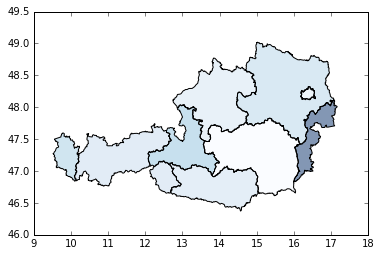

In [17]:
#Join local values to census tracts
local_vals = pd.DataFrame({'betas': local_gravity['param2'], 
                           'Dest':np.unique(Origin), 
                           'pseudoR2': local_gravity['pseudoR2']})
local_vals = pd.merge(local_vals, austria_shp[['NUTS_ID', 'geometry']],
                      left_on='Dest', right_on='NUTS_ID')
local_vals = gp.GeoDataFrame(local_vals)

#Plot betas - use inverse so the most negative values are "higher"
fig = plt.figure()
ax = fig.add_subplot(111)
local_vals['inv_betas'] = (local_vals['betas']*-1)
local_vals.plot('inv_betas', cmap='Blues', ax=ax)

Next, lets map the local $R^2$ values. Above we can see a much stronger distance-decay for the most westerly municipality. Below we can see that the model fit in stronger in the north-west but decrease in the south-east. Using these patterns, we could then further postulate why they arise or how we might be able to imrpove model fit. 

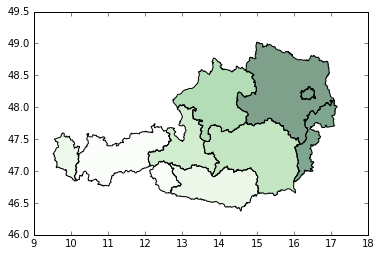

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
local_vals.plot('pseudoR2', cmap='Greens', ax=ax)

## Further functionality

In addition to all of the feature presented here, there are several other tools that exist in SpInt or could be added. First, there are dispersion tests avaialbe in the **dispersion** namespace of the SpInt module, which can be used to test whether or not the Poisson equidispersion asusmpotion is met. That is, that the conditional mean and variance are equivalent, which can be unrealistic in many scenarios. If these tests indicate overdispersion or underdispersion, then it might be appropriate to use a Quasi-Poisson model, which relaxes the equidispersion assumption of the Poisson model. The resulting parameter estimates are equivalent to the Poisson model, but the standard errors are typically larger whenever equidispersion does not hold (Wedderburn, 1974). The Quasi-Poisson model specification can be carried out by setting **Quasi=True** in and of the spatial interaction model classes. Alternatively, it might be more appropriate to change the underlying probability model from Poisson to that of negatibe binomial or a zero-inflated model. However, this has not yet been implemented in SpInt and therefore remains as future work.

Another area of potential expansion is accommodate several paradigms for incorporating spatial effects into spatial interaction models, such as competing destinations (Fotheringham, 1983),  a spatial lag autoregressive model (LeSage & Pace, 2008), or an eigenvector spatial filter model (Chun, 2009). These paradigms require code that computes additional variables, complex calibration techniques, and specialized representations of spatial relationships. While some solutions to the later are available in the **spintW** namespace of the **weights** module of PySAL, there is still much work to be done to develop a more robust set of spatial interaction modeling tools. 

## References

1. Fotheringham, A. S., and M. E. O’Kelly. 1989. Spatial Interaction Models:Formulations and Applications. London: Kluwer Academic Publishers.

2. Wilson, A. G. 1971. “A Family of Spatial Interaction Models, and Associated Developments.” Environment and Planning A 3: 1–32.

3. Flowerdew, Robin, and Murray Aitkin. 1982. “A Method of Fitting the Gravity Model Based on the Poisson Distribution.” Journal of Regional Science 22 (2): 191–202.

4. Nelder, J. A., and R. W. M. Wedderburn. 1972. “Generalized Linear Models.” Journal of the Royal Statistical Society. Series A (General) 135 (3): 370–84.

5. Dennett, Adam. 2012. “Estimating Flows between Geographical Locations:‘get Me Started In’spatial Interaction Modelling.” Working Paper 184. CASA Working Paper Series. UCL: Citeseer.

6. McFadden, Daniel. 1974. “Conditional Logit Analysis of Qualitative Choice Behavior.” In Frontiers in Econometrics, 105–42. New York: Academic Press.

7. Knudsen, D.C., and A.S. Fotheringham. 1986. “Matrix Comparison, Goodness-of-Fit, and Spatial Interaction Modeling.” International Regional Science Review 10: 127–47.

8. Akaike, Hirotugu. 1974. “A New Look at the Statistical Model Identification.” Automatic Control, IEEE Transactions on 19 (6): 716–23.

9. Lenormand, Maxime, Sylvie Huet, Floriana Gargiulo, and Guillaume Deffuant. 2012. “A Universal Model of Commuting Networks.” PLoS ONE 7 (10): e45985.

10. Yan, Xiao-Yong, Chen Zhao, Ying Fan, Zengru Di, and Wen-Xu Wang. 2013. “Universal Predictability of Mobility Patterns in Cities.” arXiv:1307.7502 [physics], July.

11. Masucci, A. P., J. Serras, A. Johansson, and M. Batty. 2012. “Gravity vs Radiation Model: On the Importance of Scale and Heterogeneity in Commuting Flows.” arXiv:1206.5735 [physics], June

12. LeSage, James P., and R. Kelley Pace. 2008. “Spatial Econometric Modeling Of Origin-Destination Flows.” Journal of Regional Science 48 (5): 941–67.

13. Tiefelsdorf, M, and B Boots. 1995. “The Specification of Constrained Interaction Models Using the SPSS Loglinear Procedure.” Geographical Systems 2: 21–38.

14. Kordi, Maryam, Christian Kaiser, and A. Stewart Fotheringham. 2012. “A Possible Solution for the Centroid-to-Centroid and Intra-Zonal Trip Length Problems.” In International Conference on Geographic Information Science, Avignon.

15. Tsutsumi, Morito, and Kazuki Tamesue. 2012. “Intraregional Flow Problem in Spatial Econometric Model for Origin–destination Flows.” Environment and Planning B: Planning and Design 39 (6): 1006–15.

16. Fotheringham, A. S. 1983. “A New Set of Spatial-Interaction Models: The Theory of Competing Destinations.” Environment and Planning A 15 (1): 15–36.

17. Chun, Yongwan. 2008. “Modeling Network Autocorrelation within Migration Flows by Eigenvector Spatial Filtering.” Journal of Geographical Systems 10 (4): 317–44.

18. Fotheringham, A. Stewart, and Chris Brunsdon. 1999. “Local Forms of Spatial Analysis.” Geographical Analysis 31 (4): 340–58.

19. Wedderburn, R. W. M. 1974. “Quasi-Likelihood Functions, Generalized Linear Models, and the Gauss-Newton Method.” Biometrika 61 (3): 439–47. doi:10.2307/2334725.

20. 